In [ ]:
channel_name = "jelly"
channel_name = channel_name + "YTData"

In [ ]:
# !wget https://www.dropbox.com/s/8kl7y6ld2plx447/jellyYTData.csv?dl=0

In [ ]:
FEA  = 'title' #@param ["title", "tags"]

### Pre-processing and NLP implementation

---



---



In [ ]:
import pandas as pd

loaded_data  =  pd.read_csv(channel_name+".csv")
print("Number of Videos before dropping: ",loaded_data.shape[0])

loaded_data.dropna()
print("Number of Videos after dropping: ",loaded_data.shape[0])

loaded_data = loaded_data.loc[:, ~loaded_data.columns.str.contains('^Unnamed')]

loaded_data = loaded_data.drop(['release_date', 'duration','age_in_days'], axis = 1)

loaded_data.head()

Number of Videos before dropping:  193
Number of Videos after dropping:  193


,title,views,tags,Likes
0,Roblox Build A BOAT For TREASURE Challenge!,112456,"child friendly, family friendly, kid friendly,...",7908
1,Playing Minecraft From BABY To GRANDPA…,108446,"child friendly, family friendly, kid friendly,...",6147
2,I Played a TUMBLEWEED Simulator...,117902,"child friendly, family friendly, kid friendly,...",7022
3,Minecraft But MOBS Drop *NEW* Weapons! (Overpo...,133745,"child friendly, family friendly, kid friendly,...",7454
4,Which Hole Is The REAL Finish?! (Golf It Troll),185791,"child friendly, family friendly, kid friendly,...",10278


In [ ]:
%%capture
!pip install nltk
!pip install contractions

import contractions
import re

import nltk
nltk.download('all')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk import WordNetLemmatizer
nltk.download('wordnet')
lemma = WordNetLemmatizer()

In [ ]:
def apply_NLP(x):
  x = contractions.fix(x)
  x = x.lower()
  x = re.sub(r'\d+','',x)
  x = re.sub(r'[^\w\s]', '', x)
  x = word_tokenize(x)
  x = [w for w in x if not w in stopwords.words()]
  x = [ lemma.lemmatize(w, pos = "v") for w in x]
  x = [ lemma.lemmatize(w, pos = "n") for w in x]
  for i in x:
    if(len(i)==1):
      x.remove(i)
  x = ' '.join(x)
  return x

In [ ]:
loaded_data[FEA] = loaded_data[FEA].apply(apply_NLP)
print("Number of Videos: ",loaded_data.shape[0])
loaded_data.head()

Number of Videos:  193


,title,views,tags,Likes
0,roblox build boat treasure challenge,112456,"child friendly, family friendly, kid friendly,...",7908
1,play minecraft baby grandpa,108446,"child friendly, family friendly, kid friendly,...",6147
2,play tumbleweed simulator,117902,"child friendly, family friendly, kid friendly,...",7022
3,minecraft mob drop new weapon overpower,133745,"child friendly, family friendly, kid friendly,...",7454
4,hole real finish golf troll,185791,"child friendly, family friendly, kid friendly,...",10278


### Generating Network

---



---



In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np

G = nx.Graph()
for i in range(loaded_data.shape[0]):
  G.add_node(i,BOW=loaded_data[FEA][i],Views = loaded_data['views'][i])

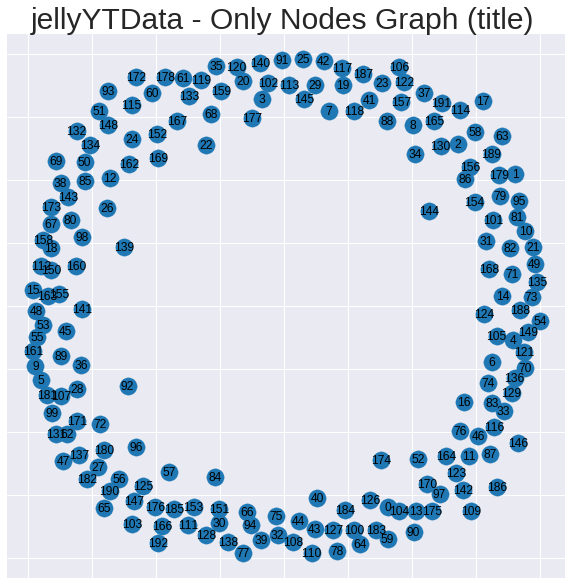

In [ ]:
plt.figure(figsize=(10,10))

pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, with_labels=True)

plt.title(channel_name + " - Only Nodes Graph (" + FEA+ ") ",fontsize=30)

plt.savefig(channel_name + "Nwk 1 (" + FEA + ").jpg")

plt.show()

In [ ]:
def get_common(x,y):
  x = x.split(" ")
  y = y.split(" ")
  return len(list(set(x)&set(y)))

In [ ]:
for i in range(loaded_data.shape[0]):
  for j in range(loaded_data.shape[0]):
    if(i!=j):
      t = get_common(loaded_data[FEA][i],loaded_data[FEA][j])
      if(t!=0):
        G.add_edge(i,j,weight=t)

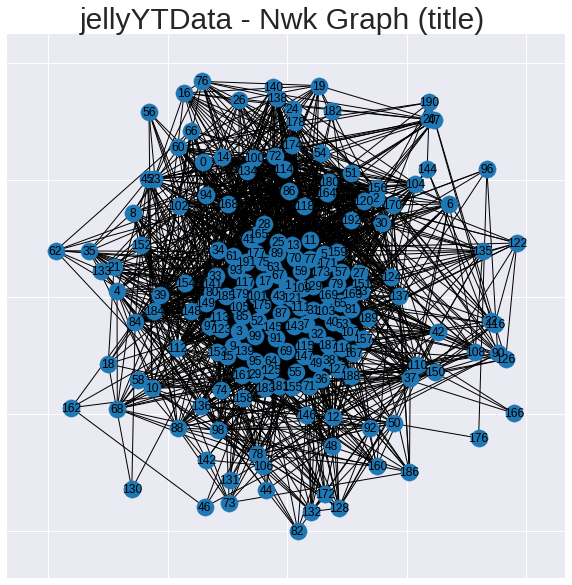

In [ ]:
plt.figure(figsize=(10,10))

pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, with_labels=True)

plt.title(channel_name + " - Nwk Graph ("+FEA+") ",fontsize=30)

plt.savefig(channel_name + "Nwk 2 ("+FEA+").jpg")
plt.show()

### Clustering Algorithms Implemented


---



---



In [ ]:
size = loaded_data.shape[0]
M = np.zeros((size,size))

for i in range(size):
  for j in range(size):
    t = get_common(loaded_data[FEA][i],loaded_data[FEA][j])
    M[i][j] = t

fractional_row = M[0]/np.max(M[0])
for a in range(1,np.shape(M)[0]):
  temp = M[a]/np.max(M[a])
  fractional_row = np.vstack((fractional_row,temp))

M = fractional_row
np.fill_diagonal(M,0)

In [ ]:
print(M)

[[0.         0.         0.         ... 0.         0.         0.2       ]
 [0.         0.         0.25       ... 0.         0.5        0.        ]
 [0.         0.33333333 0.         ... 0.         0.33333333 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.5        0.25       ... 0.         0.         0.        ]
 [0.2        0.         0.         ... 0.         0.         0.        ]]


#### 0. KMeans Algorithm

In [ ]:
import time
begin = time.time()

from sklearn.cluster import KMeans
k_cluster = 4
KM = KMeans(n_clusters = k_cluster,init='k-means++')
KM.fit(M)
KM_Results = KM .labels_

KM_classes = [[] for i in range(k_cluster)]
for i in range(KM_Results.shape[0]):
  v = KM_Results[i]
  KM_classes[v].append(i)

for i in range(len(KM_classes)):
  print("Class ",i," -- ",KM_classes[i])

end = time.time()
time_KMeans = end-begin

Class  0  --  [12, 32, 40, 50, 64, 78, 92, 98, 110, 128, 132, 136, 158]
Class  1  --  [3, 5, 7, 9, 11, 13, 15, 17, 25, 29, 31, 33, 41, 43, 53, 55, 57, 59, 61, 65, 69, 70, 77, 79, 85, 91, 93, 95, 97, 99, 103, 105, 113, 115, 117, 123, 125, 127, 129, 139, 141, 143, 147, 149, 153, 163, 167, 169, 171, 179, 185, 189]
Class  2  --  [0, 2, 4, 6, 8, 10, 14, 16, 18, 19, 20, 21, 22, 23, 24, 26, 28, 30, 34, 35, 37, 39, 42, 44, 45, 46, 47, 48, 51, 54, 56, 58, 60, 62, 66, 68, 72, 73, 74, 76, 80, 82, 83, 84, 86, 88, 90, 94, 96, 100, 102, 104, 106, 108, 112, 114, 116, 118, 120, 122, 124, 126, 130, 131, 133, 134, 135, 137, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192]
Class  3  --  [1, 27, 36, 38, 49, 52, 63, 67, 71, 75, 81, 87, 89, 101, 107, 109, 111, 119, 121, 145, 151, 155, 157, 159, 161, 165, 173, 175, 177, 181, 183, 187, 191]


Colors Choosen are:  ['red', 'lime', 'purple', 'blue']


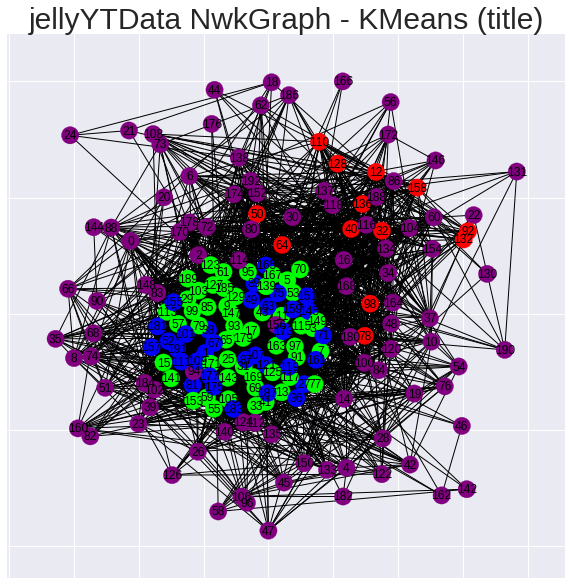

In [ ]:
# Get random colors
import random
colors = ["green","yellow","cyan","red","orange","brown","blue","magenta","purple","olive","gray","violet","lime"]
choosen_colors = random.sample(colors, k_cluster)
print("Colors Choosen are: ", choosen_colors)

color_map = []
for i in G.nodes:
  for j in range(len(KM_classes)):
    if(i in KM_classes[j]):
      color_map.append(choosen_colors[j])

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)

plt.title(channel_name+ " NwkGraph - KMeans ("+FEA+")",fontsize=30)

plt.savefig(channel_name+ " NwkGraph - KMeans.jpg")
plt.show()

In [ ]:
all_Nodes = [i[0] for i in G.nodes(data=True)]
all_BOW  = [i[1]['BOW'] for i in G.nodes(data=True)]
all_View  = [i[1]['Views'] for i in G.nodes(data=True)]
all_Comm_KM = list(KM_Results)

csv_data = {}
csv_data["Node_Number"] = all_Nodes
csv_data["Bag of Word"] = all_BOW
csv_data["Views"] = all_View
csv_data["Community"] = all_Comm_KM

KM_DF = pd.DataFrame(csv_data)
KM_DF.to_csv(channel_name + ' - KM  Final ('+FEA+').csv')
KM_DF.head()

,Node_Number,Bag of Word,Views,Community
0,0,roblox build boat treasure challenge,112456,2
1,1,play minecraft baby grandpa,108446,3
2,2,play tumbleweed simulator,117902,2
3,3,minecraft mob drop new weapon overpower,133745,1
4,4,hole real finish golf troll,185791,2


In [ ]:
print("Time taken by KMeans: ",time_KMeans," seconds.")

Time taken by KMeans:  0.2497856616973877  seconds.


#### 1. Mean-Shift Clustering Algorithm

In [ ]:
import time
begin = time.time()

from sklearn.cluster import MeanShift

MS = MeanShift()
MS.fit(M)
MS_Results = MS.labels_
M_clusters = (len(np.unique(MS.labels_)))

MS_classes = [[] for i in range(M_clusters)]
for i in range(KM_Results.shape[0]):
  v = MS_Results[i]
  MS_classes[v].append(i)

for i in range(len(MS_classes)):
  print("Class ",i," -- ",MS_classes[i])

end = time.time()
time_MShift = end-begin

Class  0  --  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 19, 20, 21, 22, 23, 24, 26, 28, 30, 32, 34, 35, 37, 39, 40, 42, 44, 45, 46, 47, 48, 50, 51, 54, 56, 58, 60, 62, 64, 66, 68, 72, 73, 74, 76, 78, 80, 82, 83, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192]
Class  1  --  [1, 3, 5, 7, 9, 11, 13, 15, 17, 25, 27, 29, 31, 33, 36, 41, 43, 49, 52, 53, 55, 57, 59, 61, 63, 65, 67, 69, 70, 71, 77, 79, 81, 85, 87, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 113, 115, 117, 121, 123, 125, 127, 129, 139, 141, 143, 145, 147, 149, 151, 153, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191]
Class  2  --  [75, 89]
Class  3  --  [38, 111, 119, 155]


Colors Choosen are:  ['brown', 'yellow', 'cyan', 'red']


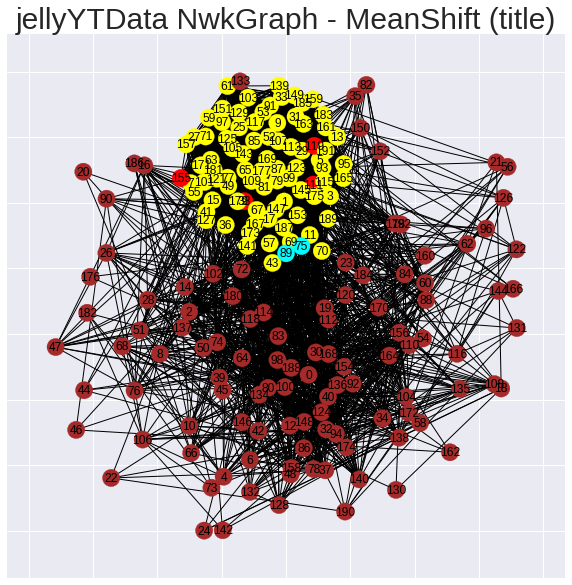

In [ ]:
# Get random colors
import random
colors = ["green","yellow","cyan","red","orange","brown","blue","magenta","purple","olive","gray","violet","lime"]
choosen_colors = random.sample(colors, M_clusters)
print("Colors Choosen are: ", choosen_colors)

color_map = []
for i in G.nodes:
  for j in range(len(MS_classes)):
    if(i in MS_classes[j]):
      color_map.append(choosen_colors[j])

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)

plt.title(channel_name+ " NwkGraph - MeanShift ("+FEA+")",fontsize=30)

plt.savefig(channel_name+ " NwkGraph - MeanShift ("+FEA+").jpg")
plt.show()

In [ ]:
all_Nodes = [i[0] for i in G.nodes(data=True)]
all_BOW  = [i[1]['BOW'] for i in G.nodes(data=True)]
all_View  = [i[1]['Views'] for i in G.nodes(data=True)]
all_Comm_MS = list(MS_Results)

csv_data = {}
csv_data["Node_Number"] = all_Nodes
csv_data["Bag of Word"] = all_BOW
csv_data["Views"] = all_View
csv_data["Community"] = all_Comm_MS

KM_DF = pd.DataFrame(csv_data)
KM_DF.to_csv(channel_name + ' - MShift  Final ('+FEA+').csv')
KM_DF.head()

,Node_Number,Bag of Word,Views,Community
0,0,roblox build boat treasure challenge,112456,0
1,1,play minecraft baby grandpa,108446,1
2,2,play tumbleweed simulator,117902,0
3,3,minecraft mob drop new weapon overpower,133745,1
4,4,hole real finish golf troll,185791,0


In [ ]:
print("Time taken by Mean Shift: ",time_MShift," seconds.")

Time taken by Mean Shift:  0.6130528450012207  seconds.


#### 2. DBSCAN – Density-Based Spatial Clustering of Applications with Noise

In [ ]:
import time
begin = time.time()
from sklearn.cluster import OPTICS

DBS = OPTICS().fit(M)
DBS_Results =  DBS.labels_
DBS_clusters = (len(np.unique(DBS.labels_)))

DBS_classes = [[] for i in range(DBS_clusters)]
for i in range(DBS_Results.shape[0]):
  v = DBS_Results[i]
  DBS_classes[v].append(i)

for i in range(len(DBS_classes)):
  print("Class ",i," -- ",DBS_classes[i])

end = time.time()
time_DBS = end-begin

Class  0  --  [20, 22, 44, 82, 130, 131, 142, 162, 166]
Class  1  --  [6, 37, 108, 135, 154]
Class  2  --  [94, 104, 134, 137, 140, 168, 170, 174]
Class  3  --  [12, 32, 40, 50, 64, 78, 92, 98, 128, 132, 136, 158]
Class  4  --  [3, 5, 7, 29, 31, 33, 55, 57, 61, 69, 77, 91, 105, 115, 123, 127, 141, 189]
Class  5  --  [27, 71, 151, 157, 161, 165, 181, 183]
Class  6  --  [1, 52, 67, 93, 109, 175, 177, 191]
Class  7  --  [0, 2, 4, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 25, 26, 28, 30, 34, 35, 36, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 51, 53, 54, 56, 58, 59, 60, 62, 63, 65, 66, 68, 70, 72, 73, 74, 75, 76, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 95, 96, 97, 99, 100, 101, 102, 103, 106, 107, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 129, 133, 138, 139, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 155, 156, 159, 160, 163, 164, 167, 169, 171, 172, 173, 176, 178, 179, 180, 182, 184, 185, 186, 187, 188, 190, 192]


Colors Choosen are:  ['olive', 'magenta', 'orange', 'violet', 'purple', 'red', 'lime', 'yellow']


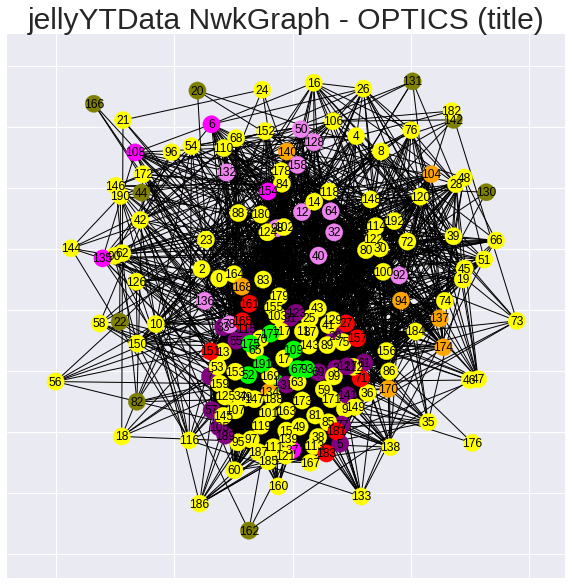

In [ ]:
# Get random colors
import random
plt.style.use('seaborn')
colors = ["green","yellow","cyan","red","orange","brown","blue","magenta","purple","olive","gray","violet","lime"]
choosen_colors = random.sample(colors, DBS_clusters)
print("Colors Choosen are: ", choosen_colors)

color_map = []
for i in G.nodes:
  for j in range(len(DBS_classes)):
    if(i in DBS_classes[j]):
      color_map.append(choosen_colors[j])

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)

plt.title(channel_name+ " NwkGraph - OPTICS ("+FEA+")",fontsize=30)

plt.savefig(channel_name+ " NwkGraph - OPTICS ("+FEA+").jpg")
plt.show()

In [ ]:
all_Nodes = [i[0] for i in G.nodes(data=True)]
all_BOW  = [i[1]['BOW'] for i in G.nodes(data=True)]
all_View  = [i[1]['Views'] for i in G.nodes(data=True)]
all_Comm_DBS = list(DBS_Results)

csv_data = {}
csv_data["Node_Number"] = all_Nodes
csv_data["Bag of Word"] = all_BOW
csv_data["Views"] = all_View
csv_data["Community"] = all_Comm_DBS

KM_DF = pd.DataFrame(csv_data)
KM_DF.to_csv(channel_name + ' - DBSCAN  Final ('+FEA+').csv')
KM_DF.head()

,Node_Number,Bag of Word,Views,Community
0,0,roblox build boat treasure challenge,112456,-1
1,1,play minecraft baby grandpa,108446,6
2,2,play tumbleweed simulator,117902,-1
3,3,minecraft mob drop new weapon overpower,133745,4
4,4,hole real finish golf troll,185791,-1


In [ ]:
print("Time taken by DBSCAN: ",time_DBS," seconds.")

Time taken by DBSCAN:  0.31339573860168457  seconds.


#### 3. EM using GMM – Expectation-Maximization (EM) Clustering using Gaussian Mixture Models (GMM)

In [ ]:
import time
begin = time.time()
from sklearn.mixture import GaussianMixture

GM_clusters = 4
GM = GaussianMixture(n_components = GM_clusters)
GM.fit(M)
GM_Results = GM.predict(M)

GM_classes = [[] for i in range(GM_clusters)]
for i in range(GM_Results.shape[0]):
  v = GM_Results[i]
  GM_classes[v].append(i)

for i in range(len(GM_classes)):
  print("Class ",i," -- ",GM_classes[i])

end = time.time()
time_GM = end-begin

Class  0  --  [2, 14, 16, 19, 23, 26, 28, 39, 47, 76, 100, 114, 120]
Class  1  --  [3, 5, 7, 9, 11, 13, 15, 17, 25, 29, 31, 33, 41, 43, 53, 55, 57, 59, 61, 65, 69, 70, 77, 79, 85, 91, 93, 95, 97, 99, 103, 105, 113, 115, 117, 123, 125, 127, 129, 139, 141, 143, 147, 149, 153, 163, 167, 169, 171, 179, 185, 189]
Class  2  --  [0, 4, 6, 8, 10, 12, 18, 20, 21, 22, 24, 30, 32, 34, 35, 37, 40, 42, 44, 45, 46, 48, 50, 51, 54, 56, 58, 60, 62, 64, 66, 68, 72, 73, 74, 78, 80, 82, 83, 84, 86, 88, 90, 92, 94, 96, 98, 102, 104, 106, 108, 110, 112, 116, 118, 122, 124, 126, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192]
Class  3  --  [1, 27, 36, 38, 49, 52, 63, 67, 71, 75, 81, 87, 89, 101, 107, 109, 111, 119, 121, 145, 151, 155, 157, 159, 161, 165, 173, 175, 177, 181, 183, 187, 191]


Colors Choosen are:  ['orange', 'cyan', 'yellow', 'magenta']


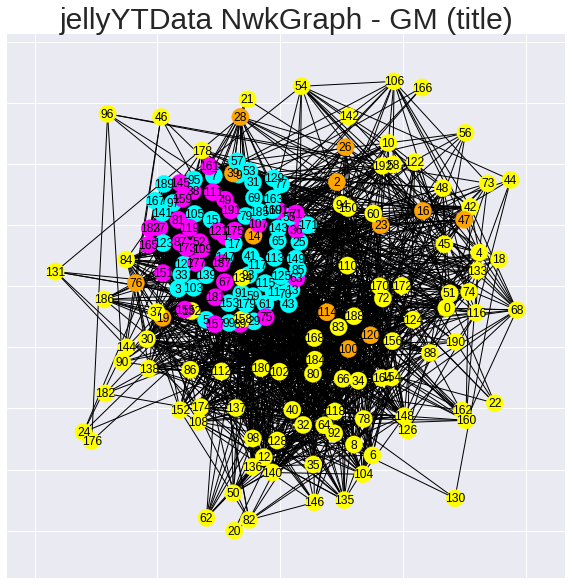

In [ ]:
# Get random colors
import random
colors = ["green","yellow","cyan","red","orange","brown","blue","magenta","purple","olive","gray","violet","lime"]
choosen_colors = random.sample(colors, GM_clusters)
print("Colors Choosen are: ", choosen_colors)

color_map = []
for i in G.nodes:
  for j in range(len(GM_classes)):
    if(i in GM_classes[j]):
      color_map.append(choosen_colors[j])

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.6, iterations=20)
nx.draw_networkx(G, pos, node_color=color_map,with_labels=True)

plt.title(channel_name+ " NwkGraph - GM ("+FEA+")",fontsize=30)

plt.savefig(channel_name+ " NwkGraph - GM ("+FEA+").jpg")
plt.show()

In [ ]:
print("Time taken by DBSCAN: ",time_GM," seconds.")

Time taken by DBSCAN:  0.10827493667602539  seconds.


In [ ]:
all_Nodes = [i[0] for i in G.nodes(data=True)]
all_BOW  = [i[1]['BOW'] for i in G.nodes(data=True)]
all_View  = [i[1]['Views'] for i in G.nodes(data=True)]
all_Comm_GM = list(GM_Results)

csv_data = {}
csv_data["Node_Number"] = all_Nodes
csv_data["Bag of Word"] = all_BOW
csv_data["Views"] = all_View
csv_data["Community"] = all_Comm_GM

GM_DF = pd.DataFrame(csv_data)
GM_DF.to_csv(channel_name + ' - GM  Final ('+FEA+').csv')
GM_DF.head()

,Node_Number,Bag of Word,Views,Community
0,0,roblox build boat treasure challenge,112456,2
1,1,play minecraft baby grandpa,108446,3
2,2,play tumbleweed simulator,117902,0
3,3,minecraft mob drop new weapon overpower,133745,1
4,4,hole real finish golf troll,185791,2


### Create Box Plots, Strip Plot and Violin Plot

---



---



#### 1. K-Means

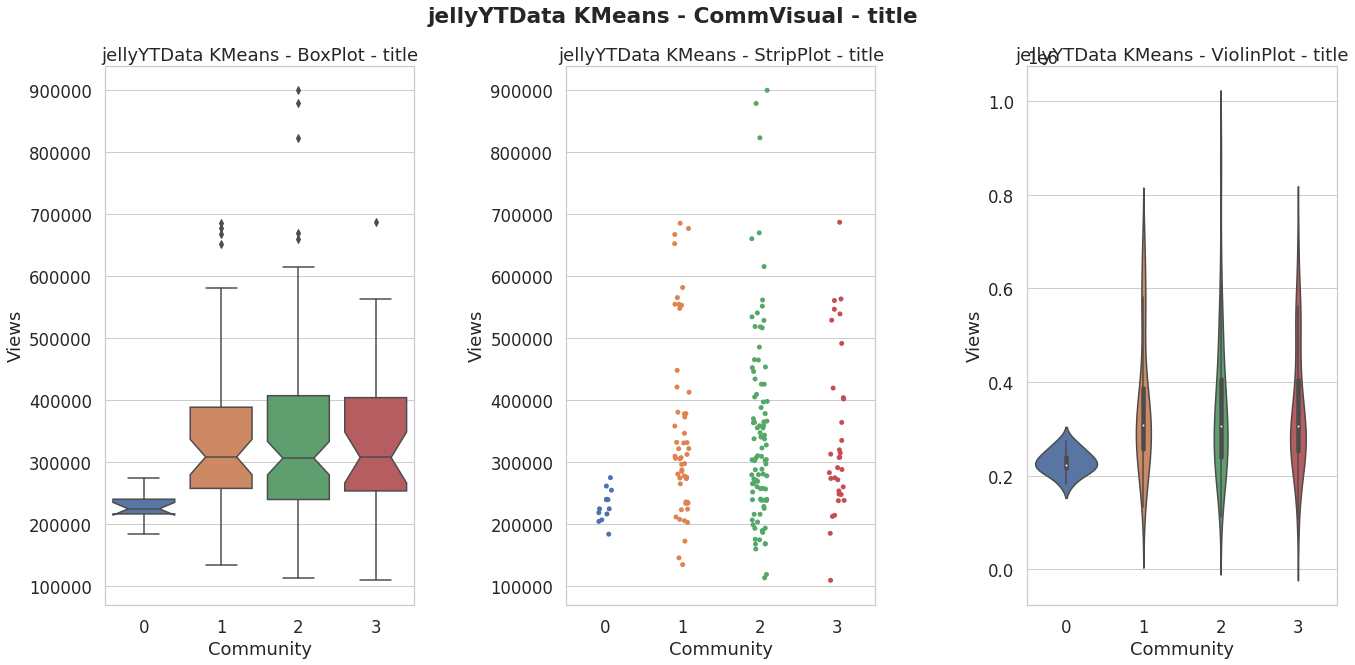

In [ ]:
LD_KM = pd.read_csv(channel_name + ' - KM  Final ('+FEA+').csv')
LD_KM = LD_KM.loc[:, ~LD_KM.columns.str.contains('^Unnamed')]
LD_KM.head()

import seaborn as sns
sns.set(rc={'figure.figsize':(11,11)}, font_scale=1.5, style='whitegrid')

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
KM_BP = sns.boxplot(x='Community',y='Views',data=LD_KM,notch=True).set_title(channel_name + ' KMeans - BoxPlot - '+ FEA)

plt.subplot(1,3,2)
KM_SP = ax = sns.stripplot(x="Community", y="Views",data=LD_KM).set_title(channel_name + ' KMeans - StripPlot - '+ FEA)

plt.subplot(1,3,3)
KM_VP = ax = sns.violinplot(x="Community", y="Views",data=LD_KM).set_title(channel_name + ' KMeans - ViolinPlot - '+ FEA)

plt.suptitle(channel_name + " KMeans - CommVisual - "+FEA,fontweight ="bold")
plt.tight_layout(pad=3)

plt.savefig(channel_name + " KMeans - CommVisual - "+FEA+".jpg")

#### 2. Mean-Shift Clustering Algorithm

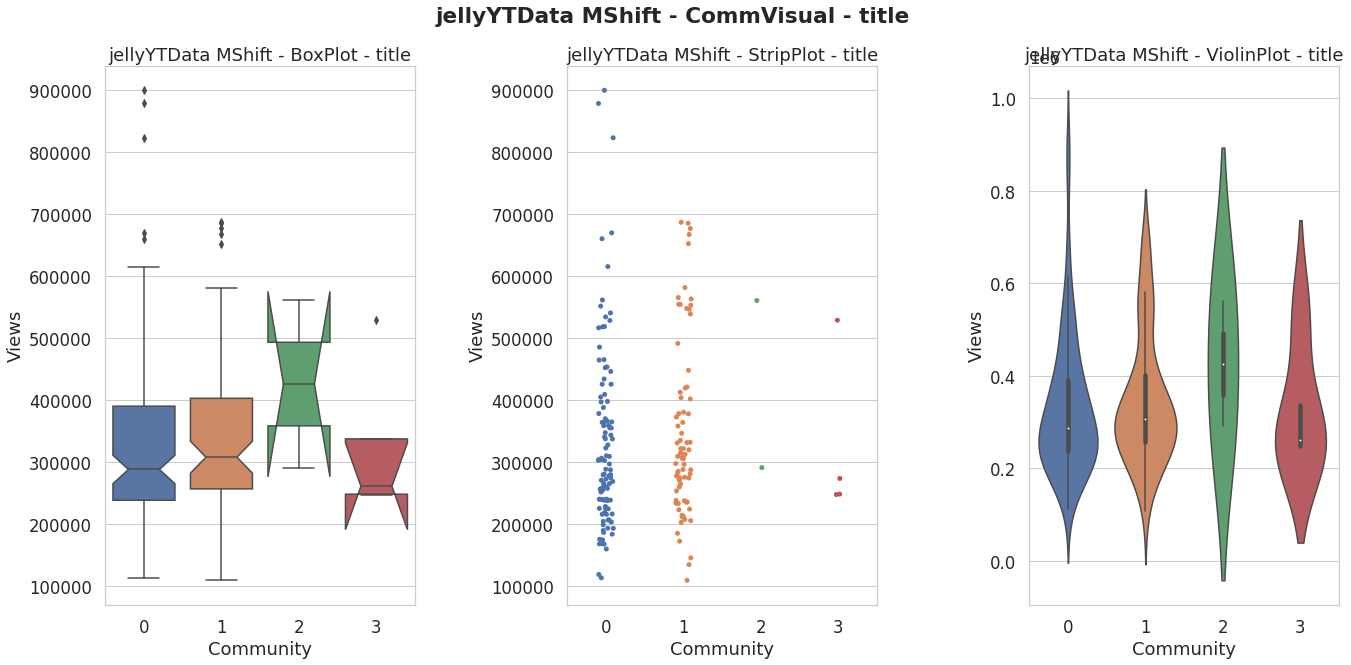

In [ ]:
LD_MShift = pd.read_csv(channel_name + ' - MShift  Final ('+FEA+').csv')
LD_MShift = LD_MShift.loc[:, ~LD_MShift.columns.str.contains('^Unnamed')]
LD_MShift.head()

import seaborn as sns
sns.set(rc={'figure.figsize':(11,11)}, font_scale=1.5, style='whitegrid')

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
MShift_BP = sns.boxplot(x='Community',y='Views',data=LD_MShift,notch=True).set_title(channel_name + ' MShift - BoxPlot - '+ FEA)

plt.subplot(1,3,2)
MShift_SP = ax = sns.stripplot(x="Community", y="Views",data=LD_MShift).set_title(channel_name + ' MShift - StripPlot - '+ FEA)

plt.subplot(1,3,3)
MShift_VP = ax = sns.violinplot(x="Community", y="Views",data=LD_MShift).set_title(channel_name + ' MShift - ViolinPlot - '+ FEA)

plt.suptitle(channel_name + " MShift - CommVisual - "+FEA,fontweight ="bold")
plt.tight_layout(pad=3)

plt.savefig(channel_name + " MShift - CommVisual - "+FEA+".jpg")

#### 3.  DBSCAN – Density-Based Spatial Clustering of Applications with Noise

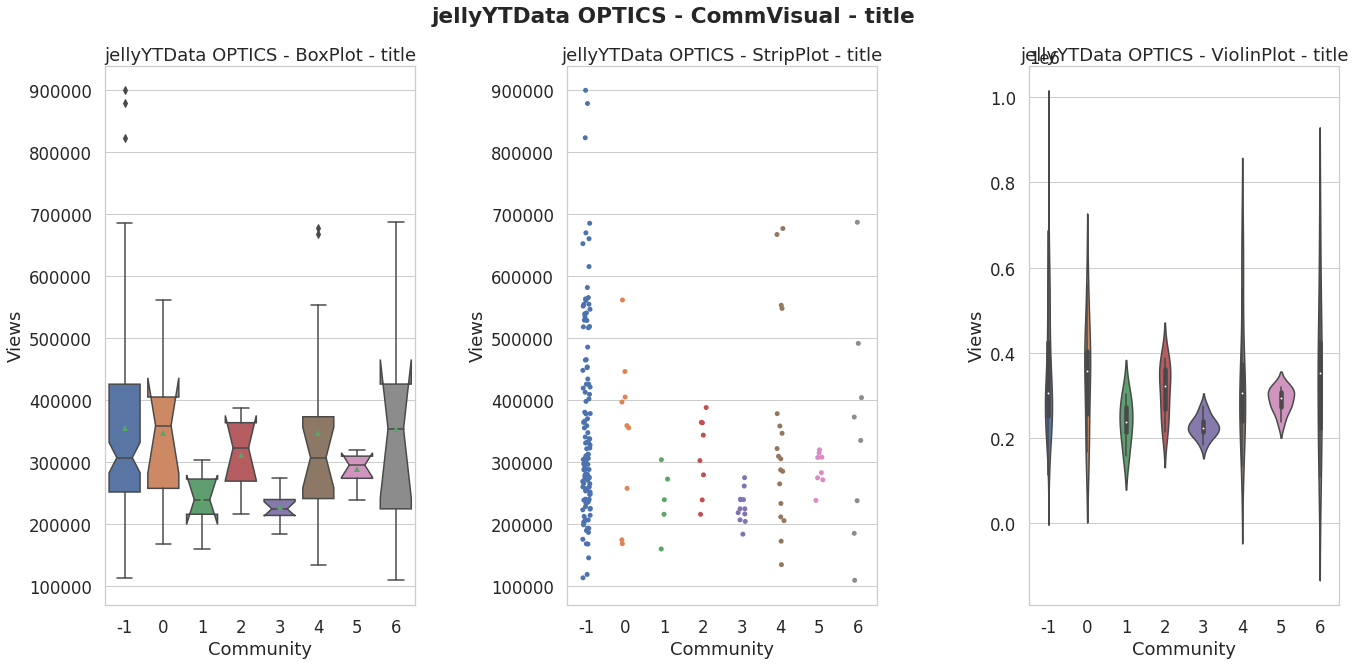

In [ ]:
LD_DBSCAN = pd.read_csv(channel_name + ' - DBSCAN  Final ('+FEA+').csv')
LD_DBSCAN = LD_DBSCAN.loc[:, ~LD_DBSCAN.columns.str.contains('^Unnamed')]
LD_DBSCAN.head()

import seaborn as sns
sns.set(rc={'figure.figsize':(11,11)}, font_scale=1.5, style='whitegrid')

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
DBSCAN_BP = sns.boxplot(x='Community',y='Views',data=LD_DBSCAN,notch=True,showmeans=True).set_title(channel_name + ' OPTICS - BoxPlot - '+ FEA)

plt.subplot(1,3,2)
DBSCAN_SP = ax = sns.stripplot(x="Community", y="Views",data=LD_DBSCAN).set_title(channel_name + ' OPTICS - StripPlot - '+ FEA)

plt.subplot(1,3,3)
DBSCAN_VP = ax = sns.violinplot(x="Community", y="Views",data=LD_DBSCAN).set_title(channel_name + ' OPTICS - ViolinPlot - '+ FEA)

plt.suptitle(channel_name + " OPTICS - CommVisual - "+FEA,fontweight ="bold")
plt.tight_layout(pad=3)

plt.savefig(channel_name + " OPTICS - CommVisual - "+FEA+".jpg")

#### 4. EM using GMM – Expectation-Maximization (EM) Clustering using Gaussian Mixture Models (GMM)

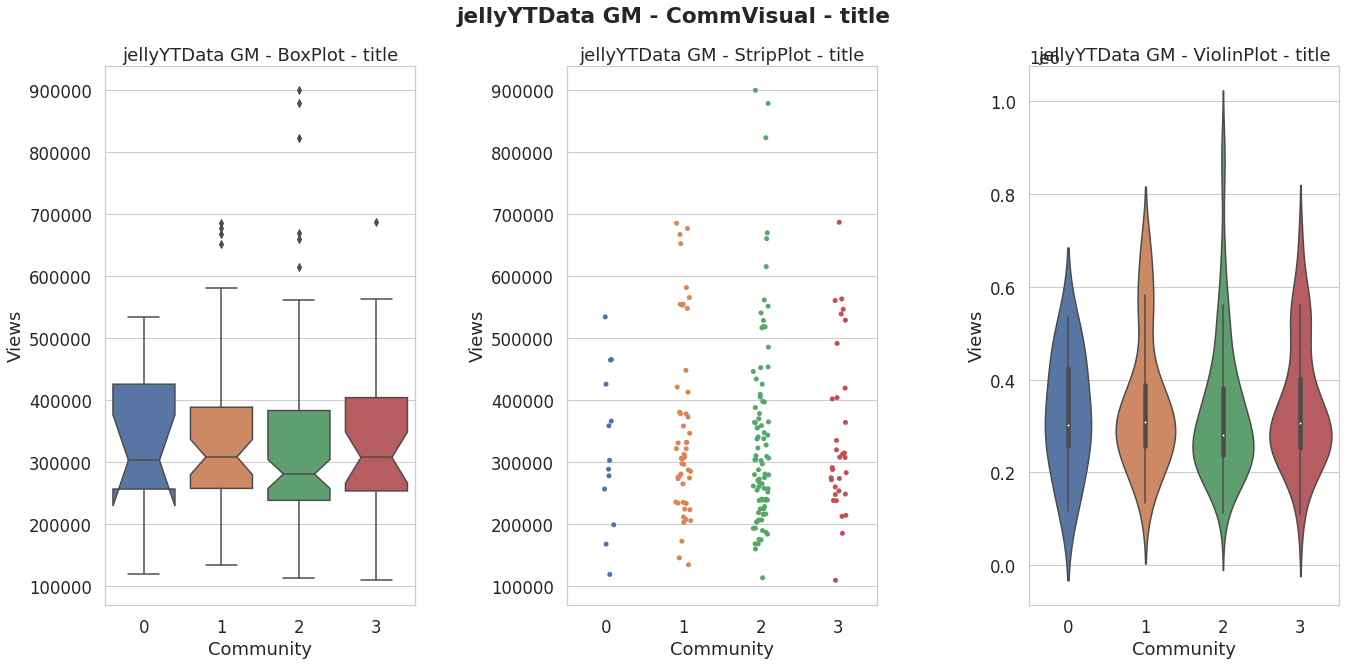

In [ ]:
LD_GM = pd.read_csv(channel_name + ' - GM  Final ('+FEA+').csv')
LD_GM = LD_GM.loc[:, ~LD_GM.columns.str.contains('^Unnamed')]
LD_GM.head()

import seaborn as sns
sns.set(rc={'figure.figsize':(11,11)}, font_scale=1.5, style='whitegrid')

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
AHC_BP = sns.boxplot(x='Community',y='Views',data=LD_GM,notch=True).set_title(channel_name + ' GM - BoxPlot - '+ FEA)

plt.subplot(1,3,2)
AHC_SP = ax = sns.stripplot(x="Community", y="Views",data=LD_GM).set_title(channel_name + ' GM - StripPlot - '+ FEA)

plt.subplot(1,3,3)
AHC_VP = ax = sns.violinplot(x="Community", y="Views",data=LD_GM).set_title(channel_name + ' GM - ViolinPlot - '+ FEA)

plt.suptitle(channel_name + " GM - CommVisual - "+FEA,fontweight ="bold")
plt.tight_layout(pad=3)

plt.savefig(channel_name + " GM - CommVisual - "+FEA+".jpg")

### Analyse all the Clustering Algorithms

---



---



In [ ]:
Analyse_all_data = {}

Analyse_all_data["Name of Algo"] = ["K-Means","OPTICS","EM using GMM"]

all_time_taken = []
all_time_taken.append(time_KMeans)
all_time_taken.append(time_DBS)
all_time_taken.append(time_GM)
Analyse_all_data["Time Taken"] = all_time_taken

all_no_comm = []
all_no_comm.append(k_cluster)
all_no_comm.append(DBS_clusters)
all_no_comm.append(GM_clusters)
Analyse_all_data["No of Communities"] = all_no_comm


Final_Analyse_Data = pd.DataFrame(Analyse_all_data)
Final_Analyse_Data.to_csv(channel_name + ' - Algorithm Analysis - 1 ('+FEA+').csv')
Final_Analyse_Data

,Name of Algo,Time Taken,No of Communities
0,K-Means,0.249786,4
1,OPTICS,0.313396,8
2,EM using GMM,0.108275,4


### Putting Everything in one .zip folder

---



---



In [ ]:
from zipfile import ZipFile
import os
files = os.listdir(os.curdir)

zipObj = ZipFile(channel_name + "- "+FEA+ '.zip', 'w')
for i in files:
  if(i.startswith(channel_name)):
    zipObj.write(i)
zipObj.close()

In [ ]:
from google.colab import files
files.download(channel_name + "- "+FEA+ '.zip')

### Clean the whole folder


In [ ]:
import os
files = os.listdir(os.curdir)
for i in files:
  if(i==".config" or i=="sample_data"):
    pass
  else:
    os.remove(i)

In [ ]:
LD_DBSCAN

,Node_Number,Bag of Word,Views,Community
0,0,roblox build boat treasure challenge,112456,-1
1,1,play minecraft baby grandpa,108446,6
2,2,play tumbleweed simulator,117902,-1
3,3,minecraft mob drop new weapon overpower,133745,4
4,4,hole real finish golf troll,185791,-1
...,...,...,...,...
188,188,gta new porsche best car ever dlc,528188,-1
189,189,minecraft optical illusion mess head,304712,4
190,190,kill seeker prop prop night,453118,-1
191,191,play poppy playtime minecraft,491115,6


In [ ]:
Most_View = int(LD_DBSCAN.groupby('Community', as_index=False)['Views'].mean().sort_values('Views').head(n=1)['Community'])
Least_View = int(LD_DBSCAN.groupby('Community', as_index=False)['Views'].mean().sort_values('Views').tail(n=1)['Community'])

In [ ]:
Most_View_BOW = list(LD_DBSCAN[LD_DBSCAN['Community']==Most_View]['Bag of Word'])

F_Most_View_BOW = []
for i in Most_View_BOW:
  t = i.split(" ")
  for j in t:
    F_Most_View_BOW.append(j)

Most_View_BOW = F_Most_View_BOW

In [ ]:
Least_View_BOW = list(LD_DBSCAN[LD_DBSCAN['Community']==Least_View]['Bag of Word'])

F_Least_View_BOW = []
for i in Least_View_BOW:
  t = i.split(" ")
  for j in t:
    F_Least_View_BOW.append(j)

Least_View_BOW = F_Most_View_BOW

In [ ]:
Most_View_BOW = " ".join(Most_View_BOW)
Least_View_BOW = " ".join(Least_View_BOW)

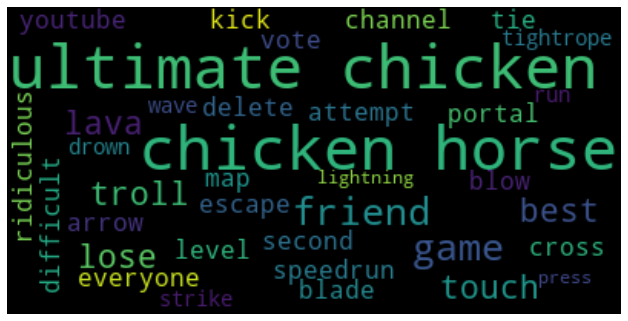

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(Most_View_BOW)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
Most_View

3

In [ ]:
Least_View

-1